## Exercise
In this part of the homework, you will reproduce some of the results in Chapter 2 of the Sutton and Barto
book.
Suppose that you have a 10-armed bandit problem—i.e., an agent has to select among a set of 10
different actions, each of which yields a different (average) reward. In particular, suppose that the actual
reward associated with each action a ∈ {1, . . . , 10} is a random variable following a Gaussian distribution
with mean Q(a) and variance 1.
You will compare the average reward received by:
• A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 0;
• A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 5;
• An ε-greedy policy, with ε = 0.1, where the estimated reward for each action a is initialized as Qˆ(a) = 0;
• An ε-greedy policy, with ε = 0.01, where the estimated reward for each action a is initialized as
Qˆ(a) = 0;
• The UCB policy.
To do this,
1. Select the average values Q(a), a ∈ {1, . . . , 10} , at random from a normal distribution with mean 0
and variance 1;
2. Run the policies listed above for 1, 000 steps and compute, for each policy, the reward received at each
time step;
3. Repeat the two previous steps 2, 000 times;
4. Compute the reward obtained at each time step by each of the policies averaged across the 2, 000 trials.

##### References
* https://www.analyticsvidhya.com/blog/2018/09/reinforcement-multi-armed-bandit-scratch-python/
* https://towardsdatascience.com/solving-multi-armed-bandit-problems-53c73940244a
* https://medium.com/@farbluestar/reinforcement-learning-part-03-355be5c7cae4
* https://medium.com/@enendufrankc/implement-a-multi-armed-bandit-algorithm-18afa2354c3f
* https://blog.gofynd.com/multi-armed-bandit-solution-methods-e85e6b19fb2d

## Solution

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import random
from abc import abstractmethod
import math
from tqdm import tqdm

In [35]:
STEPS = 1000
EPISODES = 2000
MEAN = 0
VARIANCE = 1
ACTIONS = 10  # 10-armed problem, where an agent has to select among a set of 10 different actions {1, ..., 10}
POLICIES = 5

AXIS_LABEL_FONTSIZE = 26
AXIS_TICKS_FONTSIZE = 24
LEGEND_FONTSIZE = 24
TITLE_FONTSIZE = 30

In [36]:
class Policy:
    optimistic_initilization: int
    current_step: int
    total_reward: float
    times_selected: np.array
    actions_estimated_reward: np.array
    Q_values: np.array

    def __init__(self, Q_values: np.array, optimistic_initilization: int) -> None:
        self.Q_values = Q_values
        self.optimistic_initilization = optimistic_initilization
        self.current_step = 0
        self.total_reward = 0
        self.times_selected = np.zeros(ACTIONS)
        self.actions_estimated_reward = np.full(ACTIONS, optimistic_initilization, dtype=float)

    def _get_actual_reward(self, action_index: int) -> float:
        true_reward = np.random.normal(self.Q_values[action_index], VARIANCE)
        return true_reward

    def _update(self, chosen_action_index: int) -> float:
        self.current_step += 1
        reward = self._get_actual_reward(chosen_action_index)
        self.total_reward += reward
        self.times_selected[chosen_action_index] += 1
        # Calculate average reward per action without storing all rewards
        self.actions_estimated_reward[chosen_action_index] += (
            (reward - self.actions_estimated_reward[chosen_action_index]) /
            self.times_selected[chosen_action_index]
        )
        return reward

    @abstractmethod
    def select_action(self) -> int:
        pass


class GreedyPolicy(Policy):
    def __init__(self, Q_values: np.array, optimistic_initilization: int) -> None:
        super().__init__(Q_values, optimistic_initilization)

    def select_action(self) -> float:
        # Agent needs to visit each action atleast once
        # if self.current_step < ACTIONS:
        #     chosen_action_index = self.current_step
        # else:
        chosen_action_index = np.argmax(
            self.actions_estimated_reward
        )  # Find index of highest value action
        return self._update(chosen_action_index)

    def __repr__(self):
        return f"GreedyPolicy(optimistic_initilization={self.optimistic_initilization})"


class EpsilonGreedyPolicy(GreedyPolicy):
    epsilon: float

    def __init__(self, Q_values: np.array, optimistic_initilization, epsilon) -> None:
        super().__init__(Q_values, optimistic_initilization)
        self.epsilon = epsilon

    def select_action(self) -> float:
        # if self.current_step < ACTIONS:
        #     chosen_action_index = self.current_step
        #     return self._update(chosen_action_index)
        # else:
        r = random.uniform(
            0, 1
        )  # Choose random value to simulate whether the agent chooses greedy or non greedy, according to epsilon
        chosen_action_index = np.argmax(
            self.actions_estimated_reward
        )  # Find index of highest value action
        column_indexes = list(range(0, ACTIONS))

        # Epsilon: choose a random action
        if r < self.epsilon:
            #column_indexes.remove(chosen_action_index)
            chosen_action_index = random.choice(
                column_indexes
            )  # Choose a random action index that is not the greedy choice
            return self._update(chosen_action_index)      
        # Non epsilon: choose greedily
        else:
            return self._update(chosen_action_index)
                
    def __repr__(self):
        return f"EpsilonGreedyPolicy(optimistic_initilization={self.optimistic_initilization},epsilon={self.epsilon})"


class UCBPolicy(Policy):
    c: int

    def __init__(
        self, Q_values: np.array, optimistic_initilization: int, c: int
    ) -> None:
        super().__init__(Q_values, optimistic_initilization)
        self.c = c

    def select_action(self) -> float:
        if self.current_step < ACTIONS:
            chosen_action_index = self.current_step
        else:
            chosen_action_index = 0
            ucb_values = np.zeros(ACTIONS)
            for action_index in range(0, ACTIONS):
                if self.times_selected[action_index] > 0:
                    ucb_values[action_index] = (
                        math.sqrt(self.c * 
                            math.log(self.current_step + 1)
                            / self.times_selected[action_index]
                        )  # math.log is the natural logarithm
                    )
            chosen_action_index = np.argmax(
                self.actions_estimated_reward + ucb_values
            )
        
        return self._update(chosen_action_index)

    def __repr__(self):
        return f"UCBPolicy(c={self.c})"

In [37]:
class Game:
    Q_values: np.ndarray
    policies: list[Policy]
    rewards_by_policy: np.ndarray
    avg_rewards: np.ndarray

    def __init__(self):
        self.rewards_by_policy = np.zeros(
            (EPISODES, STEPS, POLICIES), dtype=float
        )
        self.avg_rewards = np.zeros((POLICIES, STEPS), dtype=float)

    def new_episode(self) -> None:
        self.generate_Q_values()
        greedy0 = GreedyPolicy(self.Q_values, 0)
        greedy5 = GreedyPolicy(self.Q_values, 5)
        epsilon_0_1_greedy0 = EpsilonGreedyPolicy(self.Q_values, 0, 0.1)
        epsilon_0_01_greedy0 = EpsilonGreedyPolicy(self.Q_values, 0, 0.01)
        ucb = UCBPolicy(self.Q_values, 0, 1)
        self.policies = []
        self.policies.append(greedy0)
        self.policies.append(greedy5)
        self.policies.append(epsilon_0_1_greedy0)
        self.policies.append(epsilon_0_01_greedy0)
        self.policies.append(ucb)

    def generate_Q_values(self) -> None:
        self.Q_values = np.random.normal(MEAN, VARIANCE, ACTIONS)  # Q(a) -> Step 1

    def plot_Q_values(self) -> None:
        cmap = plt.colormaps["Set1"].resampled(ACTIONS).colors
        fig = plt.figure(figsize=(8, 6))
        plt.scatter(range(len(self.Q_values)), self.Q_values, color=cmap)
        plt.title("Q values for each action")
        plt.xlabel("Actions")
        plt.ylabel("Q value")
        plt.show()

    def game_loop(self):
        for episode in range(EPISODES):  # Step 3
            self.new_episode()
            for policy_index, policy in enumerate(self.policies):
                rewards = []
                for step in range(STEPS):  # Step 2
                    reward = policy.select_action()
                    self.rewards_by_policy[
                        episode, step, policy_index
                    ] = reward
                    rewards.append(reward)
                self.avg_rewards[policy_index] += (rewards - self.avg_rewards[policy_index]) / (episode + 1)

    def plot_average_reward_per_policy_per_step(self):  # Step 4
        fig = plt.figure(figsize=(18, 12), dpi=300)
        cmap = plt.colormaps["Set1"].resampled(len(self.policies)).colors
        average_rewards = np.mean(self.rewards_by_policy, axis=0)

        for policy_index, policy in enumerate(self.policies):
            plt.plot(
                average_rewards[:, policy_index],
                color=cmap[policy_index],
                label=repr(policy),
            )

        plt.gca().tick_params(axis='both', labelsize=AXIS_TICKS_FONTSIZE)
        plt.title(
            f"Average reward obtained with each policy during the {STEPS} steps for {EPISODES} episodes",
            fontsize=TITLE_FONTSIZE
        )
        plt.xlabel("Steps", fontsize=AXIS_LABEL_FONTSIZE)
        plt.ylabel("Average reward", fontsize=AXIS_LABEL_FONTSIZE)
        plt.legend(fontsize=LEGEND_FONTSIZE)
        plt.show()

In [38]:
game = Game()
game.game_loop()
# game.plot_Q_values()

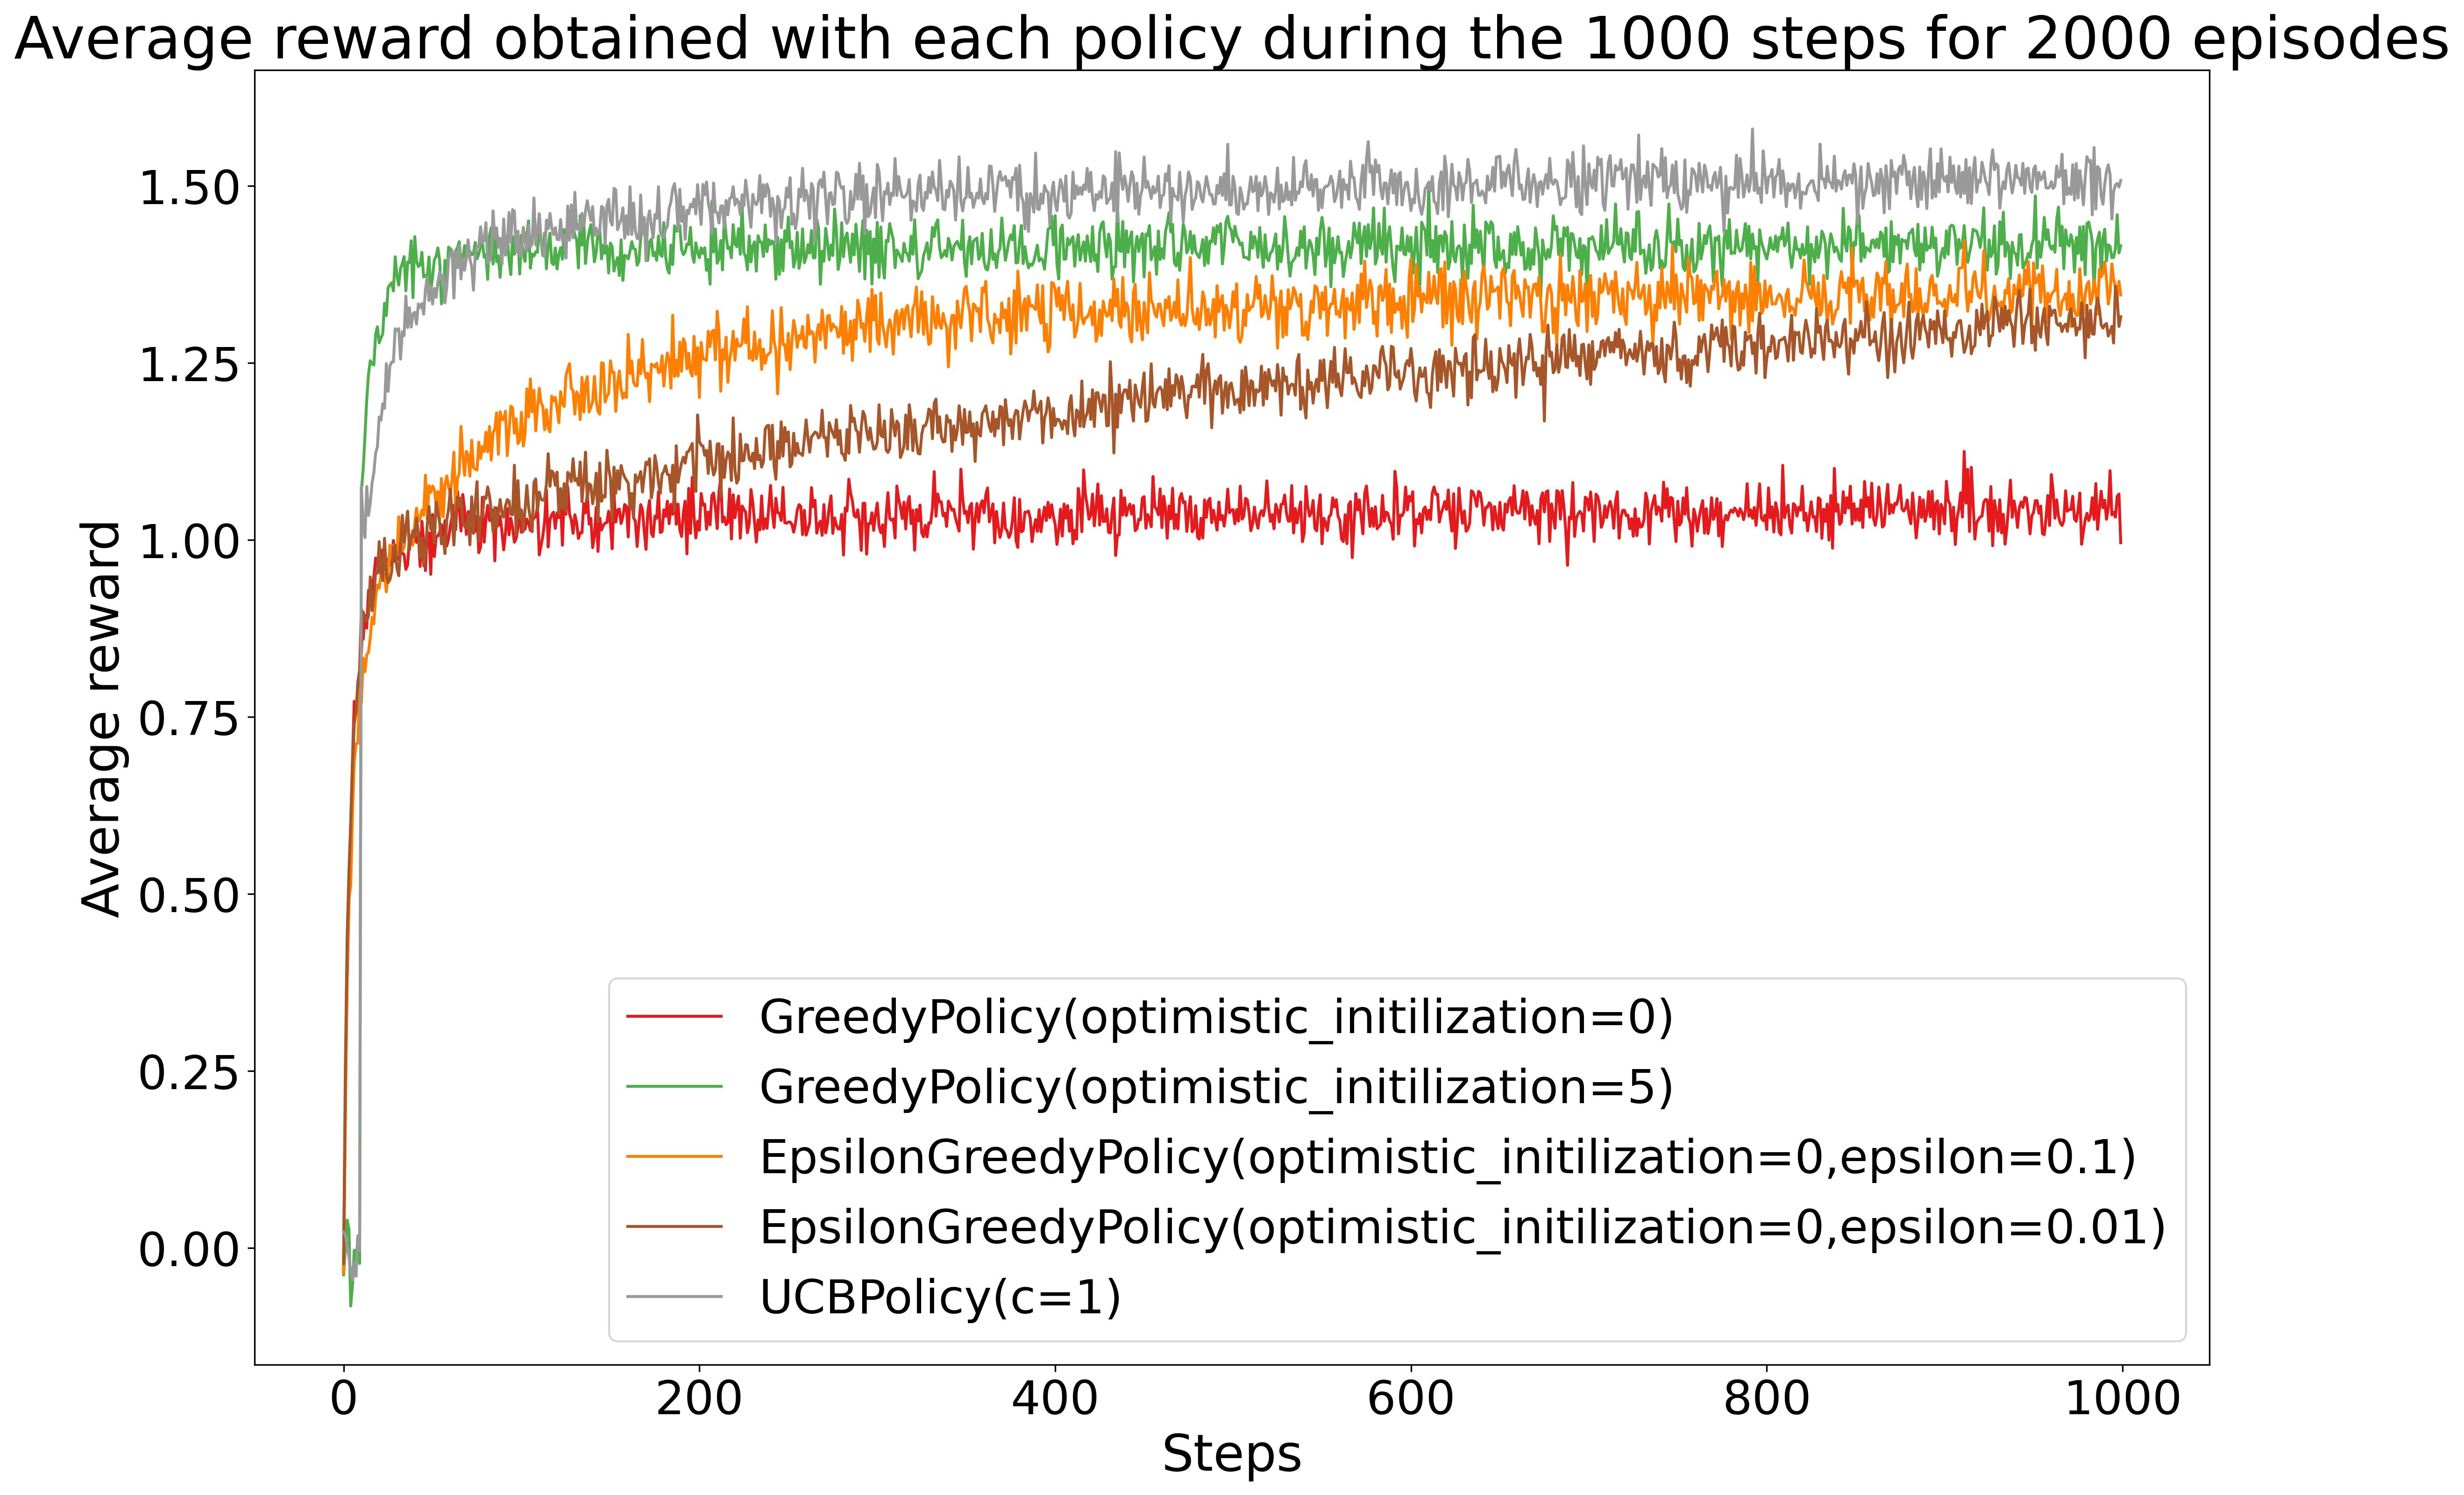

In [39]:
game.plot_average_reward_per_policy_per_step()

This will produce the final plot that answers **Question 1**, which plots the 1,000 steps in the x-axys, and the average reward in the y-axis, which each policy represented by a different line.